## Example 1: Soving Allen-Cahn equation in 1D with PINN
### Governing equations, boundary and initial conditions
PDE: $$ \frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} - \frac{1}{\epsilon^2} f'(u) $$
whwre $$ f(u) = (u^2 - 1)^2 / 4 $$
Domain: $$ x \in [-1, 1], t \in [0, 0.05] $$
Neumann boundary condition: $$ \frac{\partial u}{\partial x} = 0 $$
Initial condition: $$ u(x, 0) = sin(\pi x)*(x+1)^2(x-1)^2 $$

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2024-02-23 14:20:55.236834: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 14:20:55.256978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 14:20:55.256998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 14:20:55.257571: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 14:20:55.261034: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Step 1. Create a model (Feedforward Neural Network)
# Three-layer fully connected neural network with 100 nodes in each layer
n_nodes = 100
n_out = 1
model = tf.keras.Sequential([
    tf.keras.layers.Dense(n_nodes, activation='tanh'),
    tf.keras.layers.Dense(n_nodes, activation='tanh'),
    tf.keras.layers.Dense(n_nodes, activation='tanh'),
    tf.keras.layers.Dense(n_out, activation=None) # linear activation
])

2024-02-23 14:21:02.996259: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 14:21:03.016240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 14:21:03.016331: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Construct loss function for PINN
### Loss function includes three terms (residuals):
1. For boundary condition: $Loss_{BC} = MSE[u(x=\pm 1, t) - 1]$
2. For initial condition: $Loss_{IC} = MSE[u(x, t=0) - sin(\pi x)*(x-1)^2(x+1)^2]$
3. For PDE: $Loss_{PDE} = MSE[\frac{\partial u(x,t)}{\partial t} + (u-u^3)/eps^2]$
** Total loss function is the weighted sum of the above three terms: **
$$ Loss = Loss_{PDE} + w_1 Loss_{BC} + w_2 Loss_{IC} $$

In [3]:
# Step 2: Construct loss function
u0 = lambda x: np.sin(np.pi*x)*(x+1)**2*(x-1)**2 # initial condition

def loss(model, X_PDE, X_IC, X_BC):
    # X_PDE, X_IC, X_BC are training data for PDE, IC, BC. 
    #   They are numpy arrays of size N x 2: 
    #     first column is location x, second column is time t 
    # The input "model" is the neural network
    # Calculate loss of PDE: requires u_t (first order derivative), u_xx (second order derivative)
    # PDE: u_t = u_xx + (u - u^3)/eps^2
    with tf.GradientTape(persistent=True) as g:
        g.watch(X_PDE)
        u = model(X_PDE)
        u_x = g.gradient(u, X_PDE)[:, 0:1]
    u_t = g.gradient(u, X_PDE)[:, 1:2]
    u_xx = g.gradient(u_x, X_PDE)[:, 0:1]
    
    loss_PDE = tf.reduce_mean(((u_t - u_xx) * eps**2 - (u - u**3))**2)
    
    # Calculate loss of IC
    loss_IC = tf.reduce_mean((model(X_IC) - u0(X_IC[:, 0:1]))**2)
    
    # Calculate loss of BC
    with tf.GradientTape() as g2:
        g2.watch(X_BC)
        ub = model(X_BC)
    ub_x = g2.gradient(ub, X_BC)[:, 0:1]
    loss_BC = tf.reduce_mean(ub_x**2)
    
    # Total loss
    w1 = 1.
    w2 = 1.
    loss_total = loss_PDE + w1*loss_IC + w2*loss_BC
    
    return loss_total, loss_PDE, loss_IC, loss_BC

## Prepare the training data for PINN
### Training data only reuqires the collocation points of (x, t) input pairs, no need to provide the corresponding output values
### Training data includes three parts: 
1. For boundary condition:  $x=-1, 1, t \in [0, 0.05]$ 
2. For initial condition: $t = 0, x \in [-1, 1]$ 
3. For PDE: $x \in [-1, 1], t \in [0, 0.05]$

In [5]:
# Generate training data
def BC_data(Nt):
    # a matrix of size Nt x 2
    # first column is location x, second column is time t
    # x is random -1 or 1, t is random in [0, 0.05]
    x = np.random.choice([-1, 1], size=(Nt, 1))
    t = np.random.rand(Nt, 1)*0.05 
    X = np.hstack((x, t))
    return tf.constant(X, dtype=tf.float32)

def IC_data(Nx):
    # a matrix of size Nx x 2
    # first column is location x, second column is time t
    # x is random in [-1, 1], t is 0
    x = np.random.rand(Nx, 1)*2 - 1
    t = np.zeros((Nx, 1))
    X = np.hstack((x, t)) 
    return tf.constant(X, dtype=tf.float32)

def PDE_data(Np):
    # a matrix of size Np x 2
    # first column is location x, second column is time t
    # x is random in [-1, 1], t is random in [0, 0.05]
    x = np.random.rand(Np, 1)*2 - 1
    t = np.random.rand(Np, 1)*0.05
    X = np.hstack((x, t))
    return tf.constant(X, dtype=tf.float32)

In [6]:
# Step 3.0. Generate training data

Nt = 100  # number of training data for BC
Nx = 200  # number of training data for IC
Np = 4000 # number of training data for PDE

X_BC = BC_data(Nt)
X_IC = IC_data(Nx)
X_PDE = PDE_data(Np)

# Create a dataset object for X_PDE
X_PDE_dataset = tf.data.Dataset.from_tensor_slices(X_PDE)
# Shuffle and batch data
X_PDE_dataset = X_PDE_dataset.shuffle(buffer_size=Np).batch(256)

In [8]:
# Paramter in Allen-Cahn equation
eps=0.1

# Step 3.1. Define optimizer
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
# Step 3.2. Define training loop
epochs = 3000
# loop over epochs, each epoch contains all batches, each batch contains batch_size data
# read data from X_PDE_dataset
for epoch in range(epochs):
    for X_PDE_batch in X_PDE_dataset:
        with tf.GradientTape() as g:
            # calculate loss
            loss_total, loss_PDE, loss_IC, loss_BC = loss(model, X_PDE_batch, X_IC, X_BC)
            #loss_total = loss_PDE + 1e6*loss_IC + loss_BC
        # calculate gradient
        grads = g.gradient(loss_total, model.trainable_variables)
        # update weights
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
    if (epoch+1) % 100 == 0:
        print('Epoch: %d, Loss: %f, Loss_PDE: %f, Loss_IC: %f, Loss_BC: %f' \
            % (epoch+1, loss_total, loss_PDE, loss_IC, loss_BC))

2024-02-23 14:23:08.887649: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-23 14:23:09.118034: I external/local_xla/xla/service/service.cc:168] XLA service 0xe9d6e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-23 14:23:09.118051: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-02-23 14:23:09.123039: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-23 14:23:09.129658: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1708716189.189118  522644 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 100, Loss: 0.041285, Loss_PDE: 0.033722, Loss_IC: 0.006658, Loss_BC: 0.000905
Epoch: 200, Loss: 0.013149, Loss_PDE: 0.009428, Loss_IC: 0.001943, Loss_BC: 0.001779
Epoch: 300, Loss: 0.005908, Loss_PDE: 0.004770, Loss_IC: 0.000681, Loss_BC: 0.000456
Epoch: 400, Loss: 0.003743, Loss_PDE: 0.002138, Loss_IC: 0.000966, Loss_BC: 0.000639
Epoch: 500, Loss: 0.002666, Loss_PDE: 0.002178, Loss_IC: 0.000395, Loss_BC: 0.000093
Epoch: 600, Loss: 0.005680, Loss_PDE: 0.001942, Loss_IC: 0.000690, Loss_BC: 0.003048
Epoch: 700, Loss: 0.002149, Loss_PDE: 0.001021, Loss_IC: 0.000456, Loss_BC: 0.000673
Epoch: 800, Loss: 0.002106, Loss_PDE: 0.001446, Loss_IC: 0.000488, Loss_BC: 0.000172
Epoch: 900, Loss: 0.005342, Loss_PDE: 0.002207, Loss_IC: 0.000527, Loss_BC: 0.002608
Epoch: 1000, Loss: 0.002038, Loss_PDE: 0.001277, Loss_IC: 0.000699, Loss_BC: 0.000062
Epoch: 1100, Loss: 0.002107, Loss_PDE: 0.000908, Loss_IC: 0.000191, Loss_BC: 0.001008
Epoch: 1200, Loss: 0.002207, Loss_PDE: 0.001502, Loss_IC: 0.000

In [9]:
def plot_2D(xlim=None, ylim=None, xticks=None, yticks=None, 
            xlabel = 'x', ylabel = 'y',
            figsize=(7.3, 5.9), label_size=18, tick_size=16, spine_width=1.5):
    
    fig, ax = plt.subplots(figsize=figsize) 

    #-----Format Axis --------------------------- 
    # labels and size
    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)
    
    # limits, ticks and size
    if xlim != None:
        ax.set_xlim(*xlim)
    if ylim != None:
        ax.set_ylim(*ylim)
        
    if xticks != None:
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        
    for tick in ax.get_xticklabels():
        #tick.set_fontname('Times New Roman')
        tick.set_fontsize(tick_size)
    for tick in ax.get_yticklabels():
        #tick.set_fontname('Times New Roman')
        tick.set_fontsize(tick_size)

    #---------- Spines -------
    ax.spines["top"].set_linewidth(spine_width)
    ax.spines["left"].set_linewidth(spine_width)
    ax.spines["right"].set_linewidth(spine_width)
    ax.spines["bottom"].set_linewidth(spine_width)
    
    return fig, ax

In [10]:
# Solve Allen-Cahn equation in 1D using finite difference method (Ground truth)
# Numerical scheme: Forward Euler in time, central difference in space
# u^{n+1}_i = u^n_i + dt*( (u^n_{i-1} - 2*u^n_i + u^n_{i+1})/dx^2 + (u^n_i - u^n_i^3)/eps**2)
def allen_cahn_fd(u,eps,dt,dx):
    Nx = u.shape[0]
    # insert 0 at the beginning and end of u0
    u0 = np.zeros(Nx+2)
    u0[1:-1] = u
    u0[0] = u0[1]
    u0[-1] = u0[-2]
    # initialize ut
    ut = np.zeros(Nx)
    for i in range(1,Nx+1):
        # Numerical scheme
        ut[i-1] = u0[i] + dt*((u0[i-1] - 2*u0[i] + u0[i+1])/dx**2 + (u0[i] - u0[i]**3)/eps**2)
    return ut
# parameters
eps = 0.1

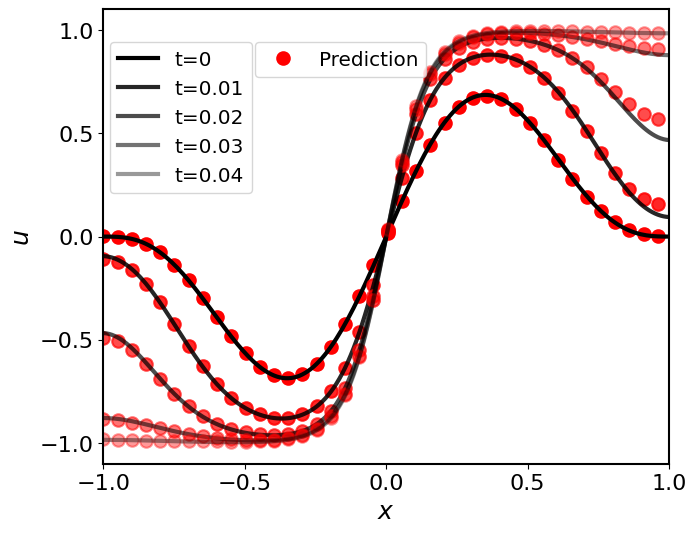

In [13]:
# Visualization
X = tf.linspace(-1., 1., 100)
X = tf.reshape(X, (-1, 1))

xlim = [-1, 1]
ylim = [-1.1, 1.1]
xticks = [-1.0, -0.5, 0, 0.5, 1.0]
yticks = xticks
xlabel = r"$\mathit{x}$"
ylabel = r"$\mathit{u}$"

fig, ax = plot_2D(xlim=xlim, ylim=ylim, xticks=xticks, yticks=yticks, xlabel=xlabel, ylabel=ylabel)

x = np.linspace(-1, 1, 200)
dt = 0.00001
dx = x[1] - x[0]

for tt in [0., 0.01, 0.02, 0.03, 0.04]:
    X_inp = tf.constant(np.hstack((x.reshape(-1, 1), tt*np.ones((200, 1)))), dtype=tf.float32)
    u_pred = model(X_inp)
    
    u_exact = u0(x)
    for _ in range(int(tt/dt)):
        u_exact = allen_cahn_fd(u_exact, eps, dt, dx)
    
    ln1, = ax.plot(x, u_pred, 'ro', markevery=5, markersize=9, 
        markeredgewidth=1.5, markerfacecolor=[1, 0, 0, 1 - 15*tt])
    if tt == 0.: 
        label_t = 't=0'
        ln = ln1
    else:
        label_t = f't={tt:.2f}'
        
    ln2, = ax.plot(x, u_exact, 'k', linewidth = 3, alpha=1 - 15*tt, label = label_t)
    
leg1 = ax.legend([ln], ['Prediction'], fontsize='x-large',  loc='upper left', bbox_to_anchor=(0.25, 0.95))
ax.legend(fontsize='x-large', bbox_to_anchor=(0.28, 0.95))
ax.add_artist(leg1)
#plt.savefig('1D_PINN-0.svg', dpi=300)